Importing Modules

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

Mounting Google Drive to access Training Data

In [2]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Loading train & test data into memory

In [3]:
trainX = np.load("drive/MyDrive/Datasets/lc2/v2/trainX.npy").astype(np.float32)
trainY = np.load("drive/MyDrive/Datasets/lc2/v2/trainY.npy").astype(np.float32)
testX = np.load("drive/MyDrive/Datasets/lc2/v2/testX.npy").astype(np.float32)
testY = np.load("drive/MyDrive/Datasets/lc2/v2/testY.npy").astype(np.float32)

In [4]:
trainX.shape

(1826, 512, 512)

Normalizing values

In [5]:
trainX = (trainX-127.0)/127.0
testX = (testX-127.0)/127.0
trainY = (trainY>127).astype(np.float32)
testY = (testY>127).astype(np.float32)

In [6]:
print(trainX.dtype)
print(trainY.dtype)
print(testX.dtype)
print(testY.dtype)

float32
float32
float32
float32


Reshaping train & test data

In [7]:
trainX = np.reshape(trainX, (len(trainX), 512, 512, 1))
trainY = np.reshape(trainY, (len(trainY), 512, 512, 1))
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print("trainX:",trainX.shape)
print("trainY:",trainY.shape)
print("testX:",testX.shape)
print("testY:",testY.shape)

trainX: (1826, 512, 512, 1)
trainY: (1826, 512, 512, 1)
testX: (457, 512, 512, 1)
testY: (457, 512, 512, 1)


Evaluation Metrics for U-Net model

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Defining U-Net model architecture

In [9]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    K.set_image_data_format('channels_last')
    
    #Encoder
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3,3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3,3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3,3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3,3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    #BottleNeck
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3,3), activation="relu", padding="same")(conv5)
    
    #Decoder
    up6 = concatenate([Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding="same")(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3,3), activation="relu", padding="same")(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), padding="same")(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3,3), activation="relu", padding="same")(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), padding="same")(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3,3), activation="relu", padding="same")(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), padding="same")(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3,3), activation="relu", padding="same")(conv9)
    
    conv10 = Conv2D(1, (1,1), activation="sigmoid")(conv9)
    
    return Model(inputs=[inputs], outputs=[conv10])

Connecting to TPU cluster system for faster training

In [10]:
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.122.202.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.202.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Callback functions for U-Net model training

In [11]:
weight_path="checkpoint-{epoch:03d}-{val_dice_coef:.3f}.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                   patience=2, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=18)

CALLBACKS = [checkpoint, early, reduceLROnPlat]

Creating U-Net model

In [12]:
with strategy.scope():
  model = unet(input_size=(512,512,1))
  model.compile(optimizer=Adam(learning_rate=2e-4),
              loss=[dice_coef_loss],
              metrics = [dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Train model

In [13]:
history = model.fit(x = trainX,
                    y = trainY,
                    batch_size = 32,
                    epochs = 200,
                    validation_data =(testX,testY),
                    callbacks=CALLBACKS
                  )

Epoch 1/200
58/58 [==============================] - ETA: 0s - loss: -0.0230 - dice_coef: 0.0356 - binary_accuracy: 0.9664
Epoch 1: val_loss improved from inf to -0.08503, saving model to checkpoint-001-0.110.hdf5
58/58 [==============================] - 79s 999ms/step - loss: -0.0230 - dice_coef: 0.0356 - binary_accuracy: 0.9664 - val_loss: -0.0850 - val_dice_coef: 0.1096 - val_binary_accuracy: 0.9960 - lr: 2.0000e-04
Epoch 2/200
58/58 [==============================] - ETA: 0s - loss: -0.1664 - dice_coef: 0.1767 - binary_accuracy: 0.9970
Epoch 2: val_loss improved from -0.08503 to -0.10811, saving model to checkpoint-002-0.133.hdf5
58/58 [==============================] - 19s 326ms/step - loss: -0.1664 - dice_coef: 0.1767 - binary_accuracy: 0.9970 - val_loss: -0.1081 - val_dice_coef: 0.1325 - val_binary_accuracy: 0.9991 - lr: 2.0000e-04
Epoch 3/200
58/58 [==============================] - ETA: 0s - loss: -0.3525 - dice_coef: 0.3597 - binary_accuracy: 0.9985
Epoch 3: val_loss improved

Plotting the history of training

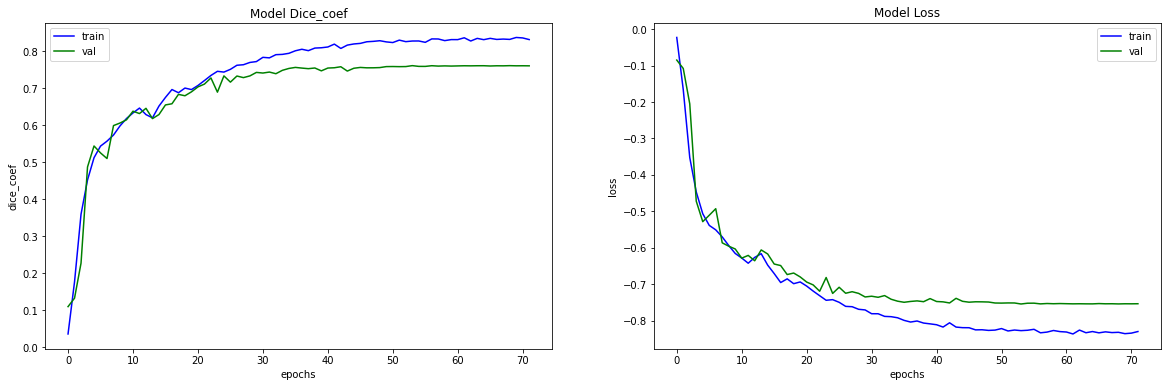

In [16]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['dice_coef', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

Saving model history for future use

In [17]:
import pickle
with open('LC_UNet_trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history
# history = pickle.load(open('DenseNet121trainHistory', "rb"))

Save the model

In [18]:
model.save("LC2_v2_UNet.h5")

In [19]:
model.evaluate(testX, testY)

15/15 [==============================] - 3s 109ms/step - loss: -0.7534 - dice_coef: 0.7612 - binary_accuracy: 0.9997


[-0.7534416317939758, 0.7611872553825378, 0.9996668696403503]

Loading the checkpoint model

In [20]:
with strategy.scope():
  model2 = unet(input_size=(512,512,1))
  model2.load_weights("checkpoint-054-0.762.hdf5")

  model2.compile(optimizer=Adam(learning_rate=2e-4),
                loss=[dice_coef_loss],
                metrics = [dice_coef, 'binary_accuracy'])

model2.evaluate(testX, testY)

15/15 [==============================] - 19s 636ms/step - loss: -0.7542 - dice_coef: 0.7617 - binary_accuracy: 0.9997


[-0.7541596293449402, 0.7617085576057434, 0.9996645450592041]

Save the checkpoint model

In [21]:
model2.save("LC2_v2_UNet_best_Model_checkpoint.h5")

Visualizing result

In [22]:
j = 1
for i in range(30,80):
  test = np.squeeze(testX)[i]
  t_p = model2.predict(np.reshape(test, (1,512,512,1)))

  plt.figure(figsize=(20,300))
  plt.subplot(50,3,j)
  plt.imshow(np.squeeze(test), cmap="bone")
  plt.subplot(50,3,j+1)
  plt.imshow(np.squeeze(t_p), cmap="gray")
  plt.subplot(50,3,j+2)
  plt.imshow(cv2.addWeighted(np.squeeze(test), .5, np.squeeze(t_p), .5, 0), cmap="gray")
  j += 3

Output hidden; open in https://colab.research.google.com to view.

Copy Saved data to google drive for future use

In [23]:
!cp LC2_v2_UNet.h5 drive/MyDrive/Datasets/lc2/v2/Training_Logs/1st_Trial/LC2_v2_UNet.h5
!cp LC_UNet_trainHistory drive/MyDrive/Datasets/lc2/v2/Training_Logs/1st_Trial/LC2_UNet_trainHistory

In [24]:
!cp LC2_v2_UNet_best_Model_checkpoint.h5 drive/MyDrive/Datasets/lc2/v2/Training_Logs/1st_Trial/LC2_UNet_best_Model_checkpoint.h5